In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Mon Jan 15 20:51:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   23C    P8    14W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 37%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.normal_mmd_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

opts = {'pz_scale': 1,
        'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
        'pz': 'normal', # 'normal', 'sphere', 'uniform'
        'zdim': hp.z_dim
       }

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.14-14/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 371016
-rw-rw-r-- 1 scpark scpark    120164  1월 15 20:51 events.out.tfevents.1705319104.GPUSVR01
-rw-rw-r-- 1 scpark scpark 379787295  1월 15 20:45 save_0
-rw-rw-r-- 1 scpark scpark        40  1월 15 20:44 events.out.tfevents.1705318860.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


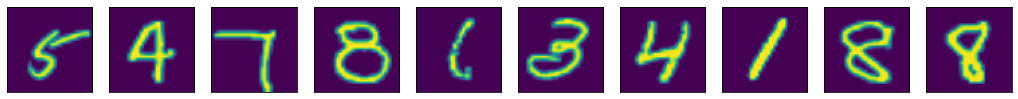

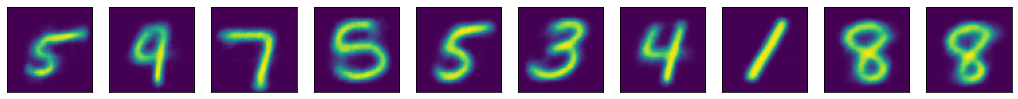

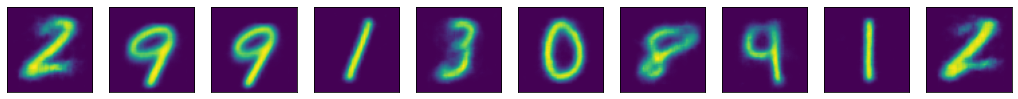

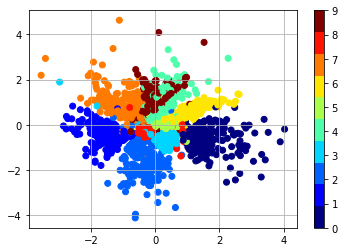

16001
mmd_loss -6.508827209472656e-06
recon_loss 0.10052985846996307
16002
mmd_loss 0.0003683209419250488
recon_loss 0.0982700116932392
16003
mmd_loss 0.00026296377182006837
recon_loss 0.09957655370235444
16004
mmd_loss -5.6242942810058595e-05
recon_loss 0.09650779739022255
16005
mmd_loss -0.0004853963851928711
recon_loss 0.09246860072016716
16006
mmd_loss -4.6420097351074216e-05
recon_loss 0.09089428707957267
16007
mmd_loss -0.0004925251007080079
recon_loss 0.09924668446183205
16008
mmd_loss -3.218650817871094e-07
recon_loss 0.09777174815535546
16009
mmd_loss 0.00038595199584960936
recon_loss 0.09750869870185852
16010
mmd_loss 6.604194641113281e-05
recon_loss 0.10073204189538956
16011
mmd_loss -0.0004064679145812988
recon_loss 0.09509833976626396
16012
mmd_loss -0.00024210214614868165
recon_loss 0.100858423858881
16013
mmd_loss -0.0008198142051696778
recon_loss 0.09517662674188614
16014
mmd_loss -8.96453857421875e-05
recon_loss 0.09798502400517464
16015
mmd_loss -0.0002576828002929687

mmd_loss -0.0005677223205566406
recon_loss 0.09826789349317551
16122
mmd_loss 9.002685546875e-05
recon_loss 0.09865913093090058
16123
mmd_loss 0.00025337934494018555
recon_loss 0.09437980204820633
16124
mmd_loss -0.00046557188034057617
recon_loss 0.10048193857073784
16125
mmd_loss 6.542205810546874e-05
recon_loss 0.0959805652499199
16126
mmd_loss 0.000332188606262207
recon_loss 0.09800059273838997
16127
mmd_loss -0.00018891096115112305
recon_loss 0.09672463461756706
16128
mmd_loss 0.00033696889877319334
recon_loss 0.09697186499834061
16129
mmd_loss 0.0025557994842529295
recon_loss 0.09886085018515586
16130
mmd_loss 5.726814270019531e-05
recon_loss 0.09293482974171638
16131
mmd_loss 0.00017505884170532227
recon_loss 0.09551295340061187
16132
mmd_loss -3.198385238647461e-05
recon_loss 0.09293948337435723
16133


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, opts=opts)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        